# Input:32 Output:32

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.80; # percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #15% for testing:0.15*4000=600

# spatial slicing dimensions
os = 32 # output slice size
ts = os  # total input slice:32 size including halos 
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 128 # number of slices in one profile 



In [3]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [4]:
# spatial slicing the profiles

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 128 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 32 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #32 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 

whole dataset features size:  (512000, 32, 3) whole dataset label size:  (512000, 32)


In [5]:
predictions = np.empty((test_size,os)) 
predictions.shape

(800, 32)

In [6]:
model=models.Sequential()
model.add(keras.Input(shape=(ts,nchan)))
model.add(Bidirectional(layers.LSTM(units=60, activation='tanh',return_sequences = True))) #kernel size 6, 60 filters for each 3 channel
model.add(Bidirectional(layers.LSTM(units=60, activation='tanh'))) #kernel size 6, 60 filters for each 3 channel
model.add(layers.Dense(os, activation="linear"))#output slice size : 32
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 32, 120)           30720     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense (Dense)                (None, 32)                3872      
Total params: 121,472
Trainable params: 121,472
Non-trainable params: 0
_________________________________________________________________


In [7]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    model=models.Sequential()
    model.add(keras.Input(shape=(ts,nchan)))
    model.add(Bidirectional(layers.LSTM(units=60, activation='tanh',return_sequences = True))) #kernel size 6, 60 filters for each 3 channel
    model.add(Bidirectional(layers.LSTM(units=60, activation='tanh'))) #kernel size 6, 60 filters for each 3 channel
    model.add(layers.Dense(os, activation="linear"))#output slice size : 32
    
    model.summary()

    ltype = 'mean_squared_error' #MSE
    type2=tf.keras.metrics.RootMeanSquaredError() #RMSE
    bsize = 1024
    eps = 2000

    model.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(15%)/trainset(85%)=0.17647

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [9]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image))
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [102400 102401 102402 ... 511997 511998 511999] TEST: [     0      1      2 ... 102397 102398 102399]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [102400 102401 102402 ... 204797 204798 204799]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [204800 204801 204802 ... 307197 307198 307199]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [307200 307201 307202 ... 409597 409598 409599]
TRAIN: [     0      1      2 ... 409597 409598 409599] TEST: [409600 409601 409602 ... 511997 511998 511999]


In [10]:
cv_scores = list()
cv_scores2 = list()
model_history = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 32, 120)           30720     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3872      
Total params: 121,472
Trainable params: 121,472
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
350/350 [==============================] - 15s 27ms/step - loss: 61.3773 - mean_squared_error: 61.3773 - root_mean_squared_error: 7.7620 - val_loss: 20.3155 - val_mean_squared_error: 20.3155 - val_root_mean_squared_error: 4.5073
Epoch 2/2000
350/350 [==============================] - 7s 19ms/step - loss: 27.2884 - mean_squared_error: 27.2884 - root_mean_squared_e

Epoch 32/2000
350/350 [==============================] - 7s 19ms/step - loss: 10.6378 - mean_squared_error: 10.6378 - root_mean_squared_error: 3.2612 - val_loss: 9.1203 - val_mean_squared_error: 9.1203 - val_root_mean_squared_error: 3.0200
Epoch 33/2000
350/350 [==============================] - 7s 19ms/step - loss: 10.0683 - mean_squared_error: 10.0683 - root_mean_squared_error: 3.1724 - val_loss: 9.0175 - val_mean_squared_error: 9.0175 - val_root_mean_squared_error: 3.0029
Epoch 34/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.9412 - mean_squared_error: 9.9412 - root_mean_squared_error: 3.1526 - val_loss: 8.8628 - val_mean_squared_error: 8.8628 - val_root_mean_squared_error: 2.9771
Epoch 35/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.7158 - mean_squared_error: 9.7158 - root_mean_squared_error: 3.1169 - val_loss: 9.5746 - val_mean_squared_error: 9.5746 - val_root_mean_squared_error: 3.0943
Epoch 36/2000
350/350 [=====================

350/350 [==============================] - 7s 19ms/step - loss: 4.1320 - mean_squared_error: 4.1320 - root_mean_squared_error: 2.0324 - val_loss: 5.3784 - val_mean_squared_error: 5.3784 - val_root_mean_squared_error: 2.3191
Epoch 101/2000
350/350 [==============================] - 7s 19ms/step - loss: 3.9990 - mean_squared_error: 3.9990 - root_mean_squared_error: 1.9994 - val_loss: 5.1763 - val_mean_squared_error: 5.1763 - val_root_mean_squared_error: 2.2751
Epoch 102/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.1227 - mean_squared_error: 4.1227 - root_mean_squared_error: 2.0291 - val_loss: 5.4523 - val_mean_squared_error: 5.4523 - val_root_mean_squared_error: 2.3350
Epoch 103/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.0889 - mean_squared_error: 4.0889 - root_mean_squared_error: 2.0216 - val_loss: 4.8574 - val_mean_squared_error: 4.8574 - val_root_mean_squared_error: 2.2040
Epoch 104/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 20ms/step - loss: 2.1416 - mean_squared_error: 2.1416 - root_mean_squared_error: 1.4634 - val_loss: 5.1527 - val_mean_squared_error: 5.1527 - val_root_mean_squared_error: 2.2700
Epoch 169/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.6883 - mean_squared_error: 2.6883 - root_mean_squared_error: 1.6393 - val_loss: 3.9764 - val_mean_squared_error: 3.9764 - val_root_mean_squared_error: 1.9941
Epoch 170/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.9942 - mean_squared_error: 2.9942 - root_mean_squared_error: 1.7291 - val_loss: 4.3791 - val_mean_squared_error: 4.3791 - val_root_mean_squared_error: 2.0926
Epoch 171/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.3923 - mean_squared_error: 2.3923 - root_mean_squared_error: 1.5459 - val_loss: 3.6456 - val_mean_squared_error: 3.6456 - val_root_mean_squared_error: 1.9093
Epoch 172/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 1.5965 - mean_squared_error: 1.5965 - root_mean_squared_error: 1.2631 - val_loss: 3.2013 - val_mean_squared_error: 3.2013 - val_root_mean_squared_error: 1.7892
Epoch 237/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.5732 - mean_squared_error: 1.5732 - root_mean_squared_error: 1.2541 - val_loss: 3.5865 - val_mean_squared_error: 3.5865 - val_root_mean_squared_error: 1.8938
Epoch 238/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.9349 - mean_squared_error: 1.9349 - root_mean_squared_error: 1.3909 - val_loss: 3.0693 - val_mean_squared_error: 3.0693 - val_root_mean_squared_error: 1.7519
Epoch 239/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.6018 - mean_squared_error: 1.6018 - root_mean_squared_error: 1.2647 - val_loss: 5.6034 - val_mean_squared_error: 5.6034 - val_root_mean_squared_error: 2.3672
Epoch 240/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 1.1183 - mean_squared_error: 1.1183 - root_mean_squared_error: 1.0574 - val_loss: 3.2463 - val_mean_squared_error: 3.2463 - val_root_mean_squared_error: 1.8018
Epoch 305/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.6192 - mean_squared_error: 1.6192 - root_mean_squared_error: 1.2722 - val_loss: 4.1033 - val_mean_squared_error: 4.1033 - val_root_mean_squared_error: 2.0257
Epoch 306/2000
350/350 [==============================] - 7s 19ms/step - loss: 3.3233 - mean_squared_error: 3.3233 - root_mean_squared_error: 1.8217 - val_loss: 3.1514 - val_mean_squared_error: 3.1514 - val_root_mean_squared_error: 1.7752
Epoch 307/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.4713 - mean_squared_error: 1.4713 - root_mean_squared_error: 1.2122 - val_loss: 2.7568 - val_mean_squared_error: 2.7568 - val_root_mean_squared_error: 1.6604
Epoch 308/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 1.0100 - mean_squared_error: 1.0100 - root_mean_squared_error: 1.0050 - val_loss: 2.6978 - val_mean_squared_error: 2.6978 - val_root_mean_squared_error: 1.6425
Epoch 373/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.1625 - mean_squared_error: 1.1625 - root_mean_squared_error: 1.0725 - val_loss: 3.3430 - val_mean_squared_error: 3.3430 - val_root_mean_squared_error: 1.8284
Epoch 374/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.2921 - mean_squared_error: 2.2921 - root_mean_squared_error: 1.5131 - val_loss: 2.5331 - val_mean_squared_error: 2.5331 - val_root_mean_squared_error: 1.5916
Epoch 375/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.1331 - mean_squared_error: 1.1331 - root_mean_squared_error: 1.0642 - val_loss: 2.4263 - val_mean_squared_error: 2.4263 - val_root_mean_squared_error: 1.5576
Epoch 376/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 0.7912 - mean_squared_error: 0.7912 - root_mean_squared_error: 0.8895 - val_loss: 2.3238 - val_mean_squared_error: 2.3238 - val_root_mean_squared_error: 1.5244
Epoch 441/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.7840 - mean_squared_error: 0.7840 - root_mean_squared_error: 0.8854 - val_loss: 2.3315 - val_mean_squared_error: 2.3315 - val_root_mean_squared_error: 1.5269
Epoch 442/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.7785 - mean_squared_error: 0.7785 - root_mean_squared_error: 0.8823 - val_loss: 2.3582 - val_mean_squared_error: 2.3582 - val_root_mean_squared_error: 1.5356
Epoch 443/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.0967 - mean_squared_error: 1.0967 - root_mean_squared_error: 1.0418 - val_loss: 3.6822 - val_mean_squared_error: 3.6822 - val_root_mean_squared_error: 1.9189
Epoch 444/2000
350/350 [==============================] - 7

Epoch 8/2000
350/350 [==============================] - 7s 19ms/step - loss: 18.3354 - mean_squared_error: 18.3354 - root_mean_squared_error: 4.2817 - val_loss: 14.9435 - val_mean_squared_error: 14.9435 - val_root_mean_squared_error: 3.8657
Epoch 9/2000
350/350 [==============================] - 7s 19ms/step - loss: 18.0602 - mean_squared_error: 18.0602 - root_mean_squared_error: 4.2490 - val_loss: 15.1713 - val_mean_squared_error: 15.1713 - val_root_mean_squared_error: 3.8950
Epoch 10/2000
350/350 [==============================] - 7s 19ms/step - loss: 17.8449 - mean_squared_error: 17.8449 - root_mean_squared_error: 4.2239 - val_loss: 14.7252 - val_mean_squared_error: 14.7252 - val_root_mean_squared_error: 3.8373
Epoch 11/2000
350/350 [==============================] - 7s 19ms/step - loss: 17.5062 - mean_squared_error: 17.5062 - root_mean_squared_error: 4.1835 - val_loss: 14.8740 - val_mean_squared_error: 14.8740 - val_root_mean_squared_error: 3.8567
Epoch 12/2000
350/350 [===========

Epoch 42/2000
350/350 [==============================] - 7s 19ms/step - loss: 8.9786 - mean_squared_error: 8.9786 - root_mean_squared_error: 2.9960 - val_loss: 9.8416 - val_mean_squared_error: 9.8416 - val_root_mean_squared_error: 3.1371
Epoch 43/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.3967 - mean_squared_error: 9.3967 - root_mean_squared_error: 3.0640 - val_loss: 9.2267 - val_mean_squared_error: 9.2267 - val_root_mean_squared_error: 3.0376
Epoch 44/2000
350/350 [==============================] - 7s 19ms/step - loss: 8.7257 - mean_squared_error: 8.7257 - root_mean_squared_error: 2.9537 - val_loss: 8.9957 - val_mean_squared_error: 8.9957 - val_root_mean_squared_error: 2.9993
Epoch 45/2000
350/350 [==============================] - 7s 20ms/step - loss: 8.7272 - mean_squared_error: 8.7272 - root_mean_squared_error: 2.9537 - val_loss: 8.4398 - val_mean_squared_error: 8.4398 - val_root_mean_squared_error: 2.9051
Epoch 46/2000
350/350 [=========================

350/350 [==============================] - 7s 19ms/step - loss: 4.2519 - mean_squared_error: 4.2519 - root_mean_squared_error: 2.0617 - val_loss: 6.0749 - val_mean_squared_error: 6.0749 - val_root_mean_squared_error: 2.4647
Epoch 111/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.1200 - mean_squared_error: 4.1200 - root_mean_squared_error: 2.0297 - val_loss: 6.2312 - val_mean_squared_error: 6.2312 - val_root_mean_squared_error: 2.4962
Epoch 112/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.5172 - mean_squared_error: 4.5172 - root_mean_squared_error: 2.1251 - val_loss: 6.0526 - val_mean_squared_error: 6.0526 - val_root_mean_squared_error: 2.4602
Epoch 113/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.2525 - mean_squared_error: 4.2525 - root_mean_squared_error: 2.0619 - val_loss: 5.8008 - val_mean_squared_error: 5.8008 - val_root_mean_squared_error: 2.4085
Epoch 114/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 2.5685 - mean_squared_error: 2.5685 - root_mean_squared_error: 1.6024 - val_loss: 4.5164 - val_mean_squared_error: 4.5164 - val_root_mean_squared_error: 2.1252
Epoch 179/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.3616 - mean_squared_error: 2.3616 - root_mean_squared_error: 1.5365 - val_loss: 4.5591 - val_mean_squared_error: 4.5591 - val_root_mean_squared_error: 2.1352
Epoch 180/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4199 - mean_squared_error: 2.4199 - root_mean_squared_error: 1.5550 - val_loss: 4.7179 - val_mean_squared_error: 4.7179 - val_root_mean_squared_error: 2.1721
Epoch 181/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4441 - mean_squared_error: 2.4441 - root_mean_squared_error: 1.5630 - val_loss: 5.3118 - val_mean_squared_error: 5.3118 - val_root_mean_squared_error: 2.3047
Epoch 182/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 1.5787 - mean_squared_error: 1.5787 - root_mean_squared_error: 1.2563 - val_loss: 4.1908 - val_mean_squared_error: 4.1908 - val_root_mean_squared_error: 2.0471
Epoch 247/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.8693 - mean_squared_error: 1.8693 - root_mean_squared_error: 1.3668 - val_loss: 3.7373 - val_mean_squared_error: 3.7373 - val_root_mean_squared_error: 1.9332
Epoch 248/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.5566 - mean_squared_error: 1.5566 - root_mean_squared_error: 1.2473 - val_loss: 4.2302 - val_mean_squared_error: 4.2302 - val_root_mean_squared_error: 2.0567
Epoch 249/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.7791 - mean_squared_error: 1.7791 - root_mean_squared_error: 1.3334 - val_loss: 6.6105 - val_mean_squared_error: 6.6105 - val_root_mean_squared_error: 2.5711
Epoch 250/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 2.2980 - mean_squared_error: 2.2980 - root_mean_squared_error: 1.5140 - val_loss: 3.4896 - val_mean_squared_error: 3.4896 - val_root_mean_squared_error: 1.8680
Epoch 315/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.4842 - mean_squared_error: 1.4842 - root_mean_squared_error: 1.2145 - val_loss: 4.0308 - val_mean_squared_error: 4.0308 - val_root_mean_squared_error: 2.0077
Epoch 316/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.8618 - mean_squared_error: 1.8618 - root_mean_squared_error: 1.3639 - val_loss: 4.2062 - val_mean_squared_error: 4.2062 - val_root_mean_squared_error: 2.0509
Epoch 317/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.5677 - mean_squared_error: 1.5677 - root_mean_squared_error: 1.2492 - val_loss: 3.4330 - val_mean_squared_error: 3.4330 - val_root_mean_squared_error: 1.8528
Epoch 318/2000
350/350 [==============================] - 7

Epoch 15/2000
350/350 [==============================] - 7s 19ms/step - loss: 16.9575 - mean_squared_error: 16.9575 - root_mean_squared_error: 4.1177 - val_loss: 13.9266 - val_mean_squared_error: 13.9266 - val_root_mean_squared_error: 3.7318
Epoch 16/2000
350/350 [==============================] - 7s 20ms/step - loss: 16.0769 - mean_squared_error: 16.0769 - root_mean_squared_error: 4.0092 - val_loss: 14.2968 - val_mean_squared_error: 14.2968 - val_root_mean_squared_error: 3.7811
Epoch 17/2000
350/350 [==============================] - 7s 19ms/step - loss: 15.8279 - mean_squared_error: 15.8279 - root_mean_squared_error: 3.9783 - val_loss: 12.7150 - val_mean_squared_error: 12.7150 - val_root_mean_squared_error: 3.5658
Epoch 18/2000
350/350 [==============================] - 7s 19ms/step - loss: 15.2535 - mean_squared_error: 15.2535 - root_mean_squared_error: 3.9055 - val_loss: 12.2503 - val_mean_squared_error: 12.2503 - val_root_mean_squared_error: 3.5000
Epoch 19/2000
350/350 [=========

350/350 [==============================] - 7s 19ms/step - loss: 4.9554 - mean_squared_error: 4.9554 - root_mean_squared_error: 2.2258 - val_loss: 5.9881 - val_mean_squared_error: 5.9881 - val_root_mean_squared_error: 2.4471
Epoch 84/2000
350/350 [==============================] - 7s 20ms/step - loss: 4.8055 - mean_squared_error: 4.8055 - root_mean_squared_error: 2.1920 - val_loss: 6.2640 - val_mean_squared_error: 6.2640 - val_root_mean_squared_error: 2.5028
Epoch 85/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.9165 - mean_squared_error: 4.9165 - root_mean_squared_error: 2.2169 - val_loss: 6.7486 - val_mean_squared_error: 6.7486 - val_root_mean_squared_error: 2.5978
Epoch 86/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.8447 - mean_squared_error: 4.8447 - root_mean_squared_error: 2.2009 - val_loss: 6.4228 - val_mean_squared_error: 6.4228 - val_root_mean_squared_error: 2.5343
Epoch 87/2000
350/350 [==============================] - 7s 19

350/350 [==============================] - 7s 19ms/step - loss: 2.4103 - mean_squared_error: 2.4103 - root_mean_squared_error: 1.5522 - val_loss: 4.5023 - val_mean_squared_error: 4.5023 - val_root_mean_squared_error: 2.1219
Epoch 152/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.5660 - mean_squared_error: 2.5660 - root_mean_squared_error: 1.6017 - val_loss: 4.3282 - val_mean_squared_error: 4.3282 - val_root_mean_squared_error: 2.0804
Epoch 153/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4370 - mean_squared_error: 2.4370 - root_mean_squared_error: 1.5609 - val_loss: 4.2794 - val_mean_squared_error: 4.2794 - val_root_mean_squared_error: 2.0687
Epoch 154/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4042 - mean_squared_error: 2.4042 - root_mean_squared_error: 1.5501 - val_loss: 5.2682 - val_mean_squared_error: 5.2682 - val_root_mean_squared_error: 2.2953
Epoch 155/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 2.7515 - mean_squared_error: 2.7515 - root_mean_squared_error: 1.6516 - val_loss: 3.3911 - val_mean_squared_error: 3.3911 - val_root_mean_squared_error: 1.8415
Epoch 220/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.5069 - mean_squared_error: 1.5069 - root_mean_squared_error: 1.2275 - val_loss: 3.2822 - val_mean_squared_error: 3.2822 - val_root_mean_squared_error: 1.8117
Epoch 221/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.4226 - mean_squared_error: 1.4226 - root_mean_squared_error: 1.1926 - val_loss: 3.8766 - val_mean_squared_error: 3.8766 - val_root_mean_squared_error: 1.9689
Epoch 222/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.6567 - mean_squared_error: 1.6567 - root_mean_squared_error: 1.2870 - val_loss: 3.8115 - val_mean_squared_error: 3.8115 - val_root_mean_squared_error: 1.9523
Epoch 223/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 9.6568 - mean_squared_error: 9.6568 - root_mean_squared_error: 3.1074 - val_loss: 9.0520 - val_mean_squared_error: 9.0520 - val_root_mean_squared_error: 3.0087
Epoch 30/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.6271 - mean_squared_error: 9.6271 - root_mean_squared_error: 3.1023 - val_loss: 9.1219 - val_mean_squared_error: 9.1219 - val_root_mean_squared_error: 3.0202
Epoch 31/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.6207 - mean_squared_error: 9.6207 - root_mean_squared_error: 3.1015 - val_loss: 8.5501 - val_mean_squared_error: 8.5501 - val_root_mean_squared_error: 2.9241
Epoch 32/2000
350/350 [==============================] - 7s 19ms/step - loss: 9.0529 - mean_squared_error: 9.0529 - root_mean_squared_error: 3.0086 - val_loss: 8.6487 - val_mean_squared_error: 8.6487 - val_root_mean_squared_error: 2.9409
Epoch 33/2000
350/350 [==============================] - 7s 20

350/350 [==============================] - 7s 19ms/step - loss: 3.9787 - mean_squared_error: 3.9787 - root_mean_squared_error: 1.9944 - val_loss: 5.4443 - val_mean_squared_error: 5.4443 - val_root_mean_squared_error: 2.3333
Epoch 98/2000
350/350 [==============================] - 7s 19ms/step - loss: 3.6865 - mean_squared_error: 3.6865 - root_mean_squared_error: 1.9199 - val_loss: 5.6702 - val_mean_squared_error: 5.6702 - val_root_mean_squared_error: 2.3812
Epoch 99/2000
350/350 [==============================] - 7s 19ms/step - loss: 3.6441 - mean_squared_error: 3.6441 - root_mean_squared_error: 1.9085 - val_loss: 5.1327 - val_mean_squared_error: 5.1327 - val_root_mean_squared_error: 2.2655
Epoch 100/2000
350/350 [==============================] - 7s 20ms/step - loss: 3.5652 - mean_squared_error: 3.5652 - root_mean_squared_error: 1.8881 - val_loss: 5.5444 - val_mean_squared_error: 5.5444 - val_root_mean_squared_error: 2.3546
Epoch 101/2000
350/350 [==============================] - 7s 

350/350 [==============================] - 7s 19ms/step - loss: 2.2993 - mean_squared_error: 2.2993 - root_mean_squared_error: 1.5163 - val_loss: 4.8925 - val_mean_squared_error: 4.8925 - val_root_mean_squared_error: 2.2119
Epoch 166/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.1320 - mean_squared_error: 2.1320 - root_mean_squared_error: 1.4599 - val_loss: 5.1459 - val_mean_squared_error: 5.1459 - val_root_mean_squared_error: 2.2685
Epoch 167/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.9849 - mean_squared_error: 2.9849 - root_mean_squared_error: 1.7265 - val_loss: 4.7238 - val_mean_squared_error: 4.7238 - val_root_mean_squared_error: 2.1734
Epoch 168/2000
350/350 [==============================] - 7s 20ms/step - loss: 2.0179 - mean_squared_error: 2.0179 - root_mean_squared_error: 1.4202 - val_loss: 4.6092 - val_mean_squared_error: 4.6092 - val_root_mean_squared_error: 2.1469
Epoch 169/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 1.4740 - mean_squared_error: 1.4740 - root_mean_squared_error: 1.2140 - val_loss: 4.0404 - val_mean_squared_error: 4.0404 - val_root_mean_squared_error: 2.0101
Epoch 234/2000
350/350 [==============================] - 7s 20ms/step - loss: 1.5080 - mean_squared_error: 1.5080 - root_mean_squared_error: 1.2275 - val_loss: 3.9350 - val_mean_squared_error: 3.9350 - val_root_mean_squared_error: 1.9837
Epoch 235/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.3396 - mean_squared_error: 1.3396 - root_mean_squared_error: 1.1574 - val_loss: 3.9740 - val_mean_squared_error: 3.9740 - val_root_mean_squared_error: 1.9935
Epoch 236/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.5589 - mean_squared_error: 1.5589 - root_mean_squared_error: 1.2456 - val_loss: 5.4345 - val_mean_squared_error: 5.4345 - val_root_mean_squared_error: 2.3312
Epoch 237/2000
350/350 [==============================] - 7

Epoch 15/2000
350/350 [==============================] - 7s 20ms/step - loss: 15.3927 - mean_squared_error: 15.3927 - root_mean_squared_error: 3.9230 - val_loss: 16.2479 - val_mean_squared_error: 16.2479 - val_root_mean_squared_error: 4.0309
Epoch 16/2000
350/350 [==============================] - 7s 20ms/step - loss: 14.8040 - mean_squared_error: 14.8040 - root_mean_squared_error: 3.8474 - val_loss: 16.4265 - val_mean_squared_error: 16.4265 - val_root_mean_squared_error: 4.0530
Epoch 17/2000
350/350 [==============================] - 7s 20ms/step - loss: 14.8644 - mean_squared_error: 14.8644 - root_mean_squared_error: 3.8553 - val_loss: 15.4509 - val_mean_squared_error: 15.4509 - val_root_mean_squared_error: 3.9308
Epoch 18/2000
350/350 [==============================] - 7s 20ms/step - loss: 14.0798 - mean_squared_error: 14.0798 - root_mean_squared_error: 3.7521 - val_loss: 16.9481 - val_mean_squared_error: 16.9481 - val_root_mean_squared_error: 4.1168
Epoch 19/2000
350/350 [=========

350/350 [==============================] - 7s 19ms/step - loss: 4.7075 - mean_squared_error: 4.7075 - root_mean_squared_error: 2.1692 - val_loss: 6.1508 - val_mean_squared_error: 6.1508 - val_root_mean_squared_error: 2.4801
Epoch 84/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.4073 - mean_squared_error: 4.4073 - root_mean_squared_error: 2.0993 - val_loss: 6.2994 - val_mean_squared_error: 6.2994 - val_root_mean_squared_error: 2.5099
Epoch 85/2000
350/350 [==============================] - 7s 19ms/step - loss: 4.4634 - mean_squared_error: 4.4634 - root_mean_squared_error: 2.1125 - val_loss: 6.3990 - val_mean_squared_error: 6.3990 - val_root_mean_squared_error: 2.5296
Epoch 86/2000
350/350 [==============================] - 7s 19ms/step - loss: 5.2880 - mean_squared_error: 5.2880 - root_mean_squared_error: 2.2988 - val_loss: 8.0473 - val_mean_squared_error: 8.0473 - val_root_mean_squared_error: 2.8368
Epoch 87/2000
350/350 [==============================] - 7s 20

350/350 [==============================] - 7s 19ms/step - loss: 2.4770 - mean_squared_error: 2.4770 - root_mean_squared_error: 1.5735 - val_loss: 4.5329 - val_mean_squared_error: 4.5329 - val_root_mean_squared_error: 2.1291
Epoch 152/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4603 - mean_squared_error: 2.4603 - root_mean_squared_error: 1.5682 - val_loss: 4.2837 - val_mean_squared_error: 4.2837 - val_root_mean_squared_error: 2.0697
Epoch 153/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.4132 - mean_squared_error: 2.4132 - root_mean_squared_error: 1.5532 - val_loss: 4.3507 - val_mean_squared_error: 4.3507 - val_root_mean_squared_error: 2.0858
Epoch 154/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.5852 - mean_squared_error: 2.5852 - root_mean_squared_error: 1.6077 - val_loss: 6.5108 - val_mean_squared_error: 6.5108 - val_root_mean_squared_error: 2.5516
Epoch 155/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 20ms/step - loss: 1.6093 - mean_squared_error: 1.6093 - root_mean_squared_error: 1.2684 - val_loss: 3.4425 - val_mean_squared_error: 3.4425 - val_root_mean_squared_error: 1.8554
Epoch 220/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.0263 - mean_squared_error: 2.0263 - root_mean_squared_error: 1.4141 - val_loss: 4.7978 - val_mean_squared_error: 4.7978 - val_root_mean_squared_error: 2.1904
Epoch 221/2000
350/350 [==============================] - 7s 19ms/step - loss: 2.3227 - mean_squared_error: 2.3227 - root_mean_squared_error: 1.5207 - val_loss: 4.4509 - val_mean_squared_error: 4.4509 - val_root_mean_squared_error: 2.1097
Epoch 222/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.8127 - mean_squared_error: 1.8127 - root_mean_squared_error: 1.3455 - val_loss: 3.4195 - val_mean_squared_error: 3.4195 - val_root_mean_squared_error: 1.8492
Epoch 223/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 20ms/step - loss: 1.2692 - mean_squared_error: 1.2692 - root_mean_squared_error: 1.1250 - val_loss: 4.2745 - val_mean_squared_error: 4.2745 - val_root_mean_squared_error: 2.0675
Epoch 288/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.9598 - mean_squared_error: 1.9598 - root_mean_squared_error: 1.3995 - val_loss: 2.8842 - val_mean_squared_error: 2.8842 - val_root_mean_squared_error: 1.6983
Epoch 289/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.9557 - mean_squared_error: 1.9557 - root_mean_squared_error: 1.3959 - val_loss: 2.8977 - val_mean_squared_error: 2.8977 - val_root_mean_squared_error: 1.7022
Epoch 290/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.1649 - mean_squared_error: 1.1649 - root_mean_squared_error: 1.0792 - val_loss: 2.8441 - val_mean_squared_error: 2.8441 - val_root_mean_squared_error: 1.6865
Epoch 291/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 0.9952 - mean_squared_error: 0.9952 - root_mean_squared_error: 0.9975 - val_loss: 2.4928 - val_mean_squared_error: 2.4928 - val_root_mean_squared_error: 1.5789
Epoch 356/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.9905 - mean_squared_error: 0.9905 - root_mean_squared_error: 0.9952 - val_loss: 2.5648 - val_mean_squared_error: 2.5648 - val_root_mean_squared_error: 1.6015
Epoch 357/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.9300 - mean_squared_error: 0.9300 - root_mean_squared_error: 0.9643 - val_loss: 2.5692 - val_mean_squared_error: 2.5692 - val_root_mean_squared_error: 1.6029
Epoch 358/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.9215 - mean_squared_error: 0.9215 - root_mean_squared_error: 0.9600 - val_loss: 4.0258 - val_mean_squared_error: 4.0258 - val_root_mean_squared_error: 2.0064
Epoch 359/2000
350/350 [==============================] - 7

350/350 [==============================] - 7s 19ms/step - loss: 2.6346 - mean_squared_error: 2.6346 - root_mean_squared_error: 1.6220 - val_loss: 3.2018 - val_mean_squared_error: 3.2018 - val_root_mean_squared_error: 1.7894
Epoch 424/2000
350/350 [==============================] - 7s 19ms/step - loss: 1.4592 - mean_squared_error: 1.4592 - root_mean_squared_error: 1.2075 - val_loss: 2.4987 - val_mean_squared_error: 2.4987 - val_root_mean_squared_error: 1.5807
Epoch 425/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.8979 - mean_squared_error: 0.8979 - root_mean_squared_error: 0.9474 - val_loss: 2.3469 - val_mean_squared_error: 2.3469 - val_root_mean_squared_error: 1.5319
Epoch 426/2000
350/350 [==============================] - 7s 19ms/step - loss: 0.8126 - mean_squared_error: 0.8126 - root_mean_squared_error: 0.9014 - val_loss: 2.3749 - val_mean_squared_error: 2.3749 - val_root_mean_squared_error: 1.5411
Epoch 427/2000
350/350 [==============================] - 7

In [11]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 3.1416 with standard deviation (0.7201)
Estimated RMSE 1.7606 with standard deviation (0.2045)


In [12]:
#quantitative reuslt: mean square error of test set
cv_scores

[2.273813247680664,
 3.5970325469970703,
 3.263197422027588,
 4.174468994140625,
 2.3996384143829346]

In [13]:
cv_scores2

[1.507916808128357,
 1.8965845108032227,
 1.8064322471618652,
 2.043151617050171,
 1.5490766763687134]

In [14]:
predictions.shape

(102400, 32)

The optimal number of epochs is 428


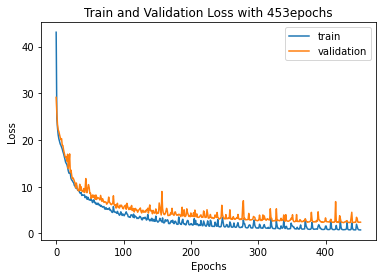

In [15]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [16]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

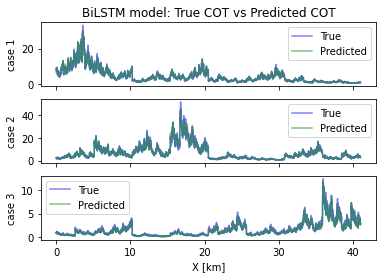

In [33]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/BiLSTM predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"BiLSTM model: True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r],data[num-2,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict2,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r],data[num-1,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict3,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

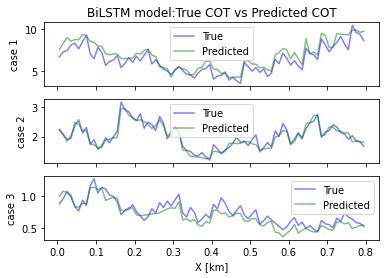

In [34]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"BiLSTM model:True COT vs Predicted COT")
ax.plot(x[:os*l2r][:80],data[num-3,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r][:80],data[num-2,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r][:80],data[num-1,:os*l2r,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')